<a href="https://colab.research.google.com/github/mengyaoo/FNL_GenesSelection/blob/main/04_TC1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Load the libraries
from __future__ import print_function

import os, sys, gzip, glob, json, time, argparse
import pandas as pd
import numpy as np
import keras
from pandas.io.json import json_normalize

from pandas.io.json import json_normalize
from keras.utils import to_categorical
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

from keras.utils import to_categorical
from keras import backend as K
from keras.layers import Input, Dense, Dropout, Activation, Conv1D, MaxPooling1D, Flatten
from keras import optimizers
from keras.optimizers import SGD, Adam, RMSprop
from keras.models import Sequential, Model, model_from_json, model_from_yaml
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau

from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import sklearn.manifold as sk_manif
from keras.utils import to_categorical

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Read features and output files 
TC1data15 = pd.read_csv("/content/drive/My Drive/FNL_TC1/TC1-S1-data15-genename.tsv", sep="\t", low_memory = False)
outcome = pd.read_csv('/content/drive/My Drive/FNL_TC1/TC1-outcome-data15-projectname.tsv', sep='\t')


In [5]:
def encode(data): 
    print('Shape of data (BEFORE encode): %s' % str(data.shape))
    encoded = to_categorical(data)
    print('Shape of data (AFTER  encode): %s\n' % str(encoded.shape))
    return encoded

In [6]:
outcome = encode(outcome['Project_id'])

Shape of data (BEFORE encode): (4500,)
Shape of data (AFTER  encode): (4500, 15)



# Train/Test split  

In [7]:
X_train, X_test, Y_train, Y_test = train_test_split(TC1data15, outcome, 
                                                    train_size=0.75, 
                                                    test_size=0.25, 
                                                    random_state=123, 
                                                    stratify = outcome)

# CONV1D 

In [8]:
# parameters  
activation='relu'
batch_size=20
# Number of sites
classes=15
drop = 0.1
feature_subsample = 0
loss='categorical_crossentropy'
# metrics='accuracy'
out_act='softmax'
pool=[1, 10]
# optimizer='sgd'
shuffle = False 
epochs=30

optimizer = optimizers.SGD(lr=0.1)
metrics = ['acc']

# X_train shape: (3375, 60483)
# X_test shape:  (1125, 60483)
# Y_train shape: (3375,1)
# Y_test shape:  (1125,1)

# 60483
x_train_len = X_train.shape[1]   

X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis=2)

# X_train shape: (3375, 60483, 1)
# X_test shape:  (1125, 60483, 1)


filters = 128 
filter_len = 20 
stride = 1 

# inside pool_list loop
pool_list = [1,10]

K.clear_session()

model = Sequential()

# model.add  CONV1D
model.add(Conv1D(filters = filters, 
                 kernel_size = filter_len, 
                 strides = stride, 
                 padding='valid', 
                 input_shape=(x_train_len, 1)))

# x_train_len = 60,483
# Activation
model.add(Activation('relu'))

# MaxPooling
model.add(MaxPooling1D(pool_size = 1))

filters = 128
filter_len = 10 
stride = 1 
# Conv1D
model.add(Conv1D(filters=filters, 
                 kernel_size=filter_len, 
                 strides=stride, 
                 padding='valid'))
# Activation
model.add(Activation('relu'))

# MaxPooling
model.add(MaxPooling1D(pool_size = 10))
model.add(Flatten())

model.add(Dense(200))

# activation 
# model.add(Activation('relu')) # SR
model.add(Activation(activation))
#dropout
model.add(Dropout(0.1))

model.add(Dense(20))
# activation
# model.add(Activation('relu')) # SR
model.add(Activation(activation))

#dropout
model.add(Dropout(0.1))

model.add(Dense(15))
model.add(Activation(out_act))

model.compile( loss= loss, 
              optimizer = optimizer, 
              metrics = metrics )
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 60464, 128)        2688      
_________________________________________________________________
activation (Activation)      (None, 60464, 128)        0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 60464, 128)        0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 60455, 128)        163968    
_________________________________________________________________
activation_1 (Activation)    (None, 60455, 128)        0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 6045, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 773760)            0

In [9]:
# save
save = '.'
output_dir = "/content/drive/My Drive/FNL_TC1/Model"
          
if not os.path.exists(output_dir): 
	os.makedirs(output_dir)

model_name = 'tc1'
path = '{}/{}.autosave.model.h5'.format(output_dir, model_name)
checkpointer = ModelCheckpoint(filepath=path, 
                               verbose=1, 
                               save_weights_only=False, 
                               save_best_only=True)
          
csv_logger = CSVLogger('{}/training.log'.format(output_dir))


In [10]:
# SR: change epsilon to min_delta
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.1, 
                              patience=10, 
                              verbose=1, mode='auto', 
                              min_delta=0.0001, 
                              cooldown=0, 
                              min_lr=0)

In [11]:
# batch_size = 20 
history = model.fit(X_train, Y_train, batch_size=batch_size, 
                    epochs=epochs, verbose=1, validation_data=(X_test, Y_test), 
                    callbacks = [checkpointer, csv_logger, reduce_lr])

score = model.evaluate(X_test, Y_test, verbose=0)

Epoch 1/30
169/169 [==============================] - 2377s 14s/step - loss: 2.8863 - acc: 0.0676 - val_loss: 2.6337 - val_acc: 0.2347

Epoch 00001: val_loss improved from inf to 2.63367, saving model to /content/drive/My Drive/FNL_TC1/Model/tc1.autosave.model.h5
Epoch 2/30
169/169 [==============================] - 2427s 14s/step - loss: 2.3059 - acc: 0.2631 - val_loss: 0.7943 - val_acc: 0.7182

Epoch 00002: val_loss improved from 2.63367 to 0.79428, saving model to /content/drive/My Drive/FNL_TC1/Model/tc1.autosave.model.h5
Epoch 3/30
169/169 [==============================] - 2464s 15s/step - loss: 0.8356 - acc: 0.7191 - val_loss: 0.3502 - val_acc: 0.8951

Epoch 00003: val_loss improved from 0.79428 to 0.35020, saving model to /content/drive/My Drive/FNL_TC1/Model/tc1.autosave.model.h5
Epoch 4/30
169/169 [==============================] - 2438s 14s/step - loss: 0.3516 - acc: 0.8806 - val_loss: 0.4165 - val_acc: 0.8524

Epoch 00004: val_loss did not improve from 0.35020
Epoch 5/30
16

In [12]:
print('Test score:', score[0])
print('Test accuracy:', score[1])

Test score: 0.19061551988124847
Test accuracy: 0.9697777628898621


Text(0.5, 0, 'epoch')

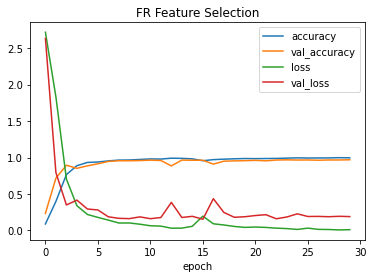

In [16]:
plt.plot(history.history['acc'],label="accuracy")
plt.plot(history.history['val_acc'],label="val_accuracy")
plt.plot(history.history['loss'],label="loss")
plt.plot(history.history['val_loss'],label="val_loss")
plt.legend()
plt.title("FR Feature Selection")
plt.xlabel('epoch')

# Finish up save model weights    

In [ ]:
# Open the handle
#from keras.models import Sequential, load_model

#loaded_model = load_model('{}/{}.autosave.model.h5'.format(output_dir, model_name))


In [ ]:

#history = loaded_model.fit(X_train, Y_train, batch_size=batch_size, 
#                 epochs=epochs, verbose=1, validation_data=(X_test, Y_test), 
#                  callbacks = [checkpointer, csv_logger, reduce_lr],initial_epoch=33)


In [14]:
# JSON JSON
# serialize model to json
json_model = model.to_json()

# save the model architecture to JSON file
with open('{}/{}.model.json'.format(output_dir, model_name), 'w') as json_file:
    json_file.write(json_model)


# YAML YAML
# serialize model to YAML
model_yaml = model.to_yaml()

# save the model architecture to YAML file
with open("{}/{}.model.yaml".format(output_dir, model_name), "w") as yaml_file:
    yaml_file.write(model_yaml)


# WEIGHTS HDF5
# serialize weights to HDF5
model.save_weights("{}/{}.model.h5".format(output_dir,model_name))
print("Saved model to disk")

Saved model to disk


In [15]:

# Open the handle
json_file = open('{}/{}.model.json'.format(output_dir, model_name), 'r')

# load json and create model
loaded_model_json = json_file.read()
json_file.close()

loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights('{}/{}.model.h5'.format(output_dir, model_name))
print("Loaded model from disk")
# loaded_model_json

# evaluate loaded model on test data
loaded_model.compile(loss='categorical_crossentropy', optimizer='sgd', 
                     metrics=['accuracy'])
score = loaded_model.evaluate(X_test, Y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk
Test score: 0.19061551988124847
Test accuracy: 0.9697777628898621
accuracy: 96.98%
